# Housing and Homelessness
- Notebook contains code and charts for data exploration, cleaning, visualization and analysis
- Created by Jeff DuBois

In [1]:
# Dependencies
import pandas as pd
import numpy as np
import requests
from pathlib import Path
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import linregress

# US census setup
from census import Census
from us import states
from config import census_key

## US Census Data
- API Dataset - American COmmuity Survey 5 year estimates (https://api.census.gov/data/2021/acs/acs5/variables.html)
- Pulled data by county for 2017-2021 (no data available for 2022

In [2]:
# Define function to retrieve US census data for a specific year and return a dataframe
def get_census_data(year):
    census_library = Census(census_key, year=year)
    state_code = states.CA.fips
    variables = [
        'NAME',
        'B01003_001E',  # Population
        'B25014_001E',  # Total Housing
        'B25014_005E',  # Housing owner occupied, 1-1.5 occupants per room
        'B25014_006E',  # Housing owner occupied, 1.5-2 occupants per room
        'B25014_007E',  # Housing owner occupied, >2 occupants per room
        'B25014_011E',  # Housing renter occupied, 1-1.5 occupants per room
        'B25014_012E',  # Housing renter occupied, 1.5-2 occupants per room
        'B25014_013E',  # Housing renter occupied, >2 occupants per room   
        'B25106_006E',  # Housing owner occupied, income <20K, housing costs >30% of income
        'B25106_010E',  # Housing owner occupied, income 20-35K, housing costs >30% of income
        'B25106_014E',  # Housing owner occupied, income 35-50K, housing costs >30% of income
        'B25106_018E',  # Housing owner occupied, income 50-75K, housing costs >30% of income
        'B25106_022E',  # Housing owner occupied, income >75K, housing costs >30% of income
        'B25106_028E',  # Housing renter occupied, income <20K, housing costs >30% of income
        'B25106_032E',  # Housing renter occupied, income 20-35K, housing costs >30% of income
        'B25106_036E',  # Housing renter occupied, income 35-50K, housing costs >30% of income
        'B25106_040E',  # Housing renter occupied, income 50-75K, housing costs >30% of income
        'B25106_044E'   # Housing renter occupied, income >75K, housing costs >30% of income 
    ]

    # Retrieve data for all counties in California
    data = census_library.acs5.state_county(variables, state_code, Census.ALL)

    # Convert to dataframe
    df = pd.DataFrame(data)
    df['Year'] = year

    # Return the dataframe
    return df

In [3]:
# Retrieve census data for multiple years and merge into one dataframe
years = [2017, 2018, 2019, 2020, 2021]

# Code reference: https://blog.finxter.com/how-to-create-a-python-list-of-size-n/
year_df = [None] * len(years)
for year in years:
    year_df[year - 2017] = get_census_data(year)

# Code reference: https://www.geeksforgeeks.org/merge-two-dataframes-with-same-column-names/
housing_df = pd.concat(year_df, axis=0)

# Export raw data to csv
file_path = Path('output_data/housing_raw_data.csv')
housing_df.to_csv(file_path, index=False)

# Display # of rows and dataframe
print(f'Number of rows: {len(housing_df)}')
housing_df.head()

,NAME,B01003_001E,B25014_001E,B25014_005E,B25014_006E,B25014_007E,B25014_011E,B25014_012E,B25014_013E,B25106_006E,...,B25106_018E,B25106_022E,B25106_028E,B25106_032E,B25106_036E,B25106_040E,B25106_044E,state,county,Year
0,"Merced County, California",267390.0,79261.0,1775.0,312.0,224.0,3801.0,849.0,326.0,3248.0,...,1844.0,1034.0,8740.0,6047.0,2963.0,656.0,76.0,06,047,2017
1,"Lake County, California",64095.0,26327.0,247.0,63.0,71.0,258.0,141.0,0.0,2217.0,...,930.0,478.0,2490.0,1747.0,497.0,220.0,44.0,06,033,2017
2,"Mariposa County, California",17658.0,7434.0,47.0,21.0,0.0,29.0,16.0,0.0,481.0,...,216.0,273.0,518.0,216.0,150.0,86.0,0.0,06,043,2017
3,"Modoc County, California",9017.0,3638.0,80.0,12.0,0.0,0.0,5.0,0.0,217.0,...,115.0,30.0,347.0,64.0,0.0,0.0,0.0,06,049,2017
4,"Yuba County, California",74644.0,25880.0,585.0,102.0,13.0,624.0,310.0,109.0,1072.0,...,1262.0,319.0,2364.0,2073.0,675.0,594.0,63.0,06,115,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53,"Tulare County, California",470999.0,139631.0,3802.0,818.0,326.0,6732.0,1529.0,704.0,5522.0,...,4872.0,2676.0,11496.0,10237.0,4945.0,1397.0,487.0,06,107,2021
54,"Tuolumne County, California",55243.0,23103.0,274.0,20.0,0.0,240.0,116.0,18.0,1409.0,...,1092.0,1534.0,1243.0,868.0,645.0,224.0,12.0,06,109,2021
55,"Ventura County, California",845255.0,274471.0,4468.0,702.0,443.0,7344.0,3315.0,1118.0,6432.0,...,11159.0,24132.0,9859.0,11185.0,11008.0,11985.0,11650.0,06,111,2021
56,"Yolo County, California",216703.0,75471.0,680.0,64.0,66.0,2764.0,1045.0,217.0,1590.0,...,1675.0,3551.0,6621.0,4499.0,2991.0,2952.0,1086.0,06,113,2021


In [94]:
# Use this to recreate dataframe if starting a new Jupyter session or Kernal
file_path = Path('output_data/housing_raw_data.csv')
housing_df = pd.read_csv(file_path)

In [95]:
# Clean up data and add calculated columns

# Rename existing columns
housing_df = housing_df.rename(
    columns = {
        'NAME': 'County',
        'B01003_001E': 'Population',
        'B25014_001E': 'Total Households'
    }
)

# Remove California from data in County column
housing_df['County'] = housing_df['County'].str.replace(', California','')

# Add columns rolling up data on overcrowded housing units
housing_df['Households Severely Overcrowded'] = (housing_df['B25014_006E'] + housing_df['B25014_007E'] +
                                              housing_df['B25014_012E'] + housing_df['B25014_013E']
                                             )
housing_df['Households Overcrowded'] = (housing_df['B25014_005E'] + housing_df['B25014_011E'] +
                                     housing_df['Households Severely Overcrowded']                                  
                                    )
housing_df['Households with Cost Burden'] = (housing_df['B25106_006E'] + housing_df['B25106_010E'] +
                                    housing_df['B25106_014E'] + housing_df['B25106_018E'] + 
                                    housing_df['B25106_022E'] + housing_df['B25106_028E'] +
                                    housing_df['B25106_032E'] + housing_df['B25106_036E'] +
                                    housing_df['B25106_040E'] + housing_df['B25106_044E']
                                   )

# Remove unneeded columns
# Code Reference: https://sparkbyexamples.com/pandas/pandas-drop-columns-by-index/
housing_clean_df = housing_df.drop(housing_df.iloc[:, 3:21], axis = 1)

# Export clean data to csv
file_path = Path('output_data/housing_clean_data.csv')
housing_clean_df.to_csv(file_path, index=False)

# Display # of rows and dataframe
print(f'Number of rows: {len(housing_clean_df)}')
housing_clean_df.head()

Number of rows: 290


,County,Population,Total Households,Year,Households Severely Overcrowded,Households Overcrowded,Households with Cost Burden
0,Merced County,267390.0,79261.0,2017,1711.0,7287.0,29818.0
1,Lake County,64095.0,26327.0,2017,275.0,780.0,10623.0
2,Mariposa County,17658.0,7434.0,2017,37.0,113.0,2378.0
3,Modoc County,9017.0,3638.0,2017,17.0,97.0,1191.0
4,Yuba County,74644.0,25880.0,2017,534.0,1743.0,10093.0


## Continuum of Care (CoC) Mapping
- Homelessness data is summarized by CoC not County, zip code, or city. CoCs are regional homelessness service coordination and planning bodies. California has 58 counties but only 44 Continuums of Care. Some counties are grouped into a single CoC and LA is divided into 3 Cocs.
- Matt created a csv file to map CoCs to counties so CoCs can be added to the housing dataframe and merged with homeless data.



In [96]:
# Create final housing dataframe that includes CoC

# Create dataframe with CoC data
file_path = Path('Resources/County-CoC Mapping.csv')
coc_mapping = pd.read_csv(file_path)

# Create dataframe with housing and CoC data
housing_coc_df = pd.merge(housing_clean_df, coc_mapping, on=['County'], how='left')
housing_coc_df = housing_coc_df.groupby(['Year', 'Continuum of Care']).sum(numeric_only=True).reset_index()

# Display # of rows and dataframe
print(f'Number of rows: {len(housing_coc_df)}')
housing_coc_df.head()

Number of rows: 205


,Year,Continuum of Care,Population,Total Households,Households Severely Overcrowded,Households Overcrowded,Households with Cost Burden
0,2017,Alameda County CoC,1629615.0,569070.0,13657.0,41529.0,218874.0
1,2017,"Alpine, Inyo, Mono Counties CoC",33456.0,13229.0,64.0,260.0,4244.0
2,2017,"Amador, Calaveras, Mariposa, Tuolumne Counties...",153920.0,61698.0,314.0,1346.0,22211.0
3,2017,Butte County CoC,225207.0,86167.0,685.0,2564.0,34750.0
4,2017,"Colusa, Glenn, Trinity Counties CoC",62451.0,22445.0,270.0,1205.0,7738.0


## CA Open Portal Data
- Dataset - Excel file with annual demographics for people experiencing homelessness between 2017 and 2022. Note there were other demographic files (age and ethnicity) but none with just homelessness counts per CoC per year. 
- People are considered to be “experiencing homelessness” at any point in the selected time frame if they:
    1) accessed lodging services through Emergency Shelter, Transitional Housing, and/or Safe Haven projects:
    2) entered into a permanent housing project from homelessness (i.e., Permanent Supportive Housing, Housing Only, Housing with Services, Rapid Re-Housing); or
    3) reported living in a homeless situation (e.g., they are living in a place not meant for habitation, such as a vehicle) at the time they accessed other services.

In [167]:
# Use this to recreate dataframe if starting a new Jupyter session or Kernal
file_path = Path('resources/experiencing_homelessness_age_demographics.csv')
homeless_df = pd.read_csv(file_path)

In [168]:
# Clean up homeless data and prep to merge with housing data

# Rename existing columns
homeless_df = homeless_df.rename(
    columns = {
        'CALENDAR_YEAR': 'Year',
        'COC_ID': 'CoC Code',
        'COC_NAME': 'Continuum of Care',
        'EXPERIENCING_HOMELESSNESS_CNT': 'Homeless Count'
    }
)

# Change homeless count data type to integer
homeless_df = homeless_df.loc[homeless_df['Homeless Count']!='*']
homeless_df['Homeless Count'] = homeless_df['Homeless Count'].astype(int)

# Remove counts for all of California
homeless_df = homeless_df.loc[homeless_df['Continuum of Care'] != 'California']

# Rename multiple CoCs in LA so they roll up into one number per year
la_cocs = ['Glendale CoC (Los Angeles County)', 'Pasadena CoC (Los Angeles County)', 'Long Beach CoC (Los Angeles County)']
homeless_df['Continuum of Care'] = homeless_df['Continuum of Care'].replace(la_cocs, 'Los Angeles County CoC')

# Group by year and COC name and sum homeless counts
homeless_df = homeless_df.groupby(['Year', 'Continuum of Care'])['Homeless Count'].sum().reset_index()

# Display # of rows and dataframe
print(f'Number of rows: {len(homeless_df)}')
homeless_df.head()

Number of rows: 244


,Year,Continuum of Care,Homeless Count
0,2017,Alameda County CoC,6713
1,2017,"Alpine, Inyo, Mono Counties CoC",151
2,2017,"Amador, Calaveras, Mariposa, Tuolumne Counties...",368
3,2017,Butte County CoC,1400
4,2017,"Colusa, Glenn, Trinity Counties CoC",190


## Final Dataframe with Housing and Homeless Data

In [99]:
# Create final dataframe merging housing and homeless data
final_df = pd.merge(housing_coc_df, homeless_df, on=['Year','Continuum of Care'], how='left')

# Add column to calculation homeless % of population
final_df['% Homeless'] = (final_df['Homeless Count'] /
                          final_df['Population']) * 100

# Add columns to calculate %s of overcrowded units
final_df['% Households Overcrowded'] = (final_df['Households Overcrowded'] /
                                     final_df['Total Households']) * 100
final_df['% Households Severely Overcrowded'] = (final_df['Households Severely Overcrowded'] /
                                            final_df['Total Households']) * 100

# Add column to calculate % of households with housing cost burden
final_df['% Households with Cost Burden'] = (final_df['Households with Cost Burden'] /
                                    final_df['Total Households']) * 100

# Reorganize columns
final_df = final_df[['Year', 'Continuum of Care',
                     'Population', 'Homeless Count', '% Homeless',
                     'Total Households', 'Households Overcrowded', '% Households Overcrowded',
                     'Households Severely Overcrowded', '% Households Severely Overcrowded',
                     'Households with Cost Burden', '% Households with Cost Burden'
                    ]]

# Drop rows for CoCs with missing data
# final_df = final_df.loc[final_df['Continuum of Care'] != 'Yuba, Sutter Counties CoC']
final_df = final_df.fillna(0)

# Export final data to csv
file_path = Path('output_data/housing_final_data.csv')
final_df.to_csv(file_path, index=False)

# Display # of rows and dataframe
print(f'Number of rows: {len(final_df)}')
final_df.head()

Number of rows: 205


,Year,Continuum of Care,Population,Homeless Count,% Homeless,Total Households,Households Overcrowded,% Households Overcrowded,Households Severely Overcrowded,% Households Severely Overcrowded,Households with Cost Burden,% Households with Cost Burden
0,2017,Alameda County CoC,1629615.0,6713.0,0.411938,569070.0,41529.0,7.297696,13657.0,2.399881,218874.0,38.461701
1,2017,"Alpine, Inyo, Mono Counties CoC",33456.0,151.0,0.451339,13229.0,260.0,1.965379,64.0,0.483786,4244.0,32.081034
2,2017,"Amador, Calaveras, Mariposa, Tuolumne Counties...",153920.0,368.0,0.239085,61698.0,1346.0,2.181594,314.0,0.508931,22211.0,35.999546
3,2017,Butte County CoC,225207.0,1400.0,0.621650,86167.0,2564.0,2.975617,685.0,0.794968,34750.0,40.328664
4,2017,"Colusa, Glenn, Trinity Counties CoC",62451.0,190.0,0.304239,22445.0,1205.0,5.368679,270.0,1.202941,7738.0,34.475384


## Analysis and Visualizations
Questions:
1. Is there a relationship between homelessness and household overcrowding and in California?
2. Is there a relationship between homelessness and household severe overcrowding and in California?
3. Is there a relationship between Homelessness and Households with housing cost burden in California?

### Functions for Visualizations

In [152]:
# Function to create Linear Regression plots
def plot_lin_reg(x_values, y_values, parems):
    
    # Set variables for linear regression and plot
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = 'y = ' + str(round(slope,2)) + 'x + ' + str(round(intercept,2))
    plt.scatter(x_values,y_values)
    plt.plot(x_values,regress_values,'r-')
    
    # Set location of regression equation - x is 5% to the right of the y axis
    xmin, xmax = plt.xlim()
    line_eq_xloc = round(xmin + ((xmax - xmin)* .05), 1)
    
    # Increase ylim max by 10% and set location for regression equation - y is 1% above previous ylim max
    ymin, ymax = plt.ylim()
    plt.ylim(ymin, round(ymax + ((ymax - ymin) * .10), 1))
    line_eq_yloc = round(ymax + ((ymax - ymin) * .01), 1)     

    # Add equation, set x/y axis labels and title
    plt.annotate(line_eq,(line_eq_xloc, line_eq_yloc), fontsize=15, color='red')
    plt.xlabel(parems['x'], fontsize=12, labelpad=6)
    plt.ylabel(parems['y'], fontsize=12, labelpad=2)
    plt.title(parems['title'], fontsize=14, pad=15, wrap=True)
    
    # Print statisical information
    print(f'The r value is: {rvalue}')
    print(f'The p value is: {pvalue}')
    
    # Save chart as an image
    plt.savefig(parems['png_path'])
    
    # Display linear regression
    plt.show()

In [15]:
# Function to create line chart with 2 different y axes
def plot_line_2y(df, parems):
    
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    
    # Setup axes labels and tick
    ax1.set_xlabel(parems['x'], fontsize=12, labelpad=6)
    ax1.set_ylabel(parems['y1'], fontsize=12, labelpad=4, color=parems['colors'][0])
    ax2.set_ylabel(parems['y2'], fontsize=12, labelpad=4, color=parems['colors'][1])
    ax1.tick_params(axis='y', labelcolor=parems['colors'][0])
    ax2.tick_params(axis='y', labelcolor=parems['colors'][1])
    
    # Setup bar chart
    ax1.plot(df.iloc[:, 0], df.iloc[:, 1], color=parems['colors'][0])
    ax2.plot(df.iloc[:, 0], df.iloc[:, 2], color=parems['colors'][1])
    
    # Set xticks and title
    plt.xticks(df.iloc[:, 0])
    plt.title(parems['title'], fontsize=14, pad=15, wrap=True)
    
    # Save the figure
    plt.savefig(parems['png_path'], bbox_inches = 'tight')
    
    # Display line chart
    plt.show()

In [28]:
# Function to create bar chart with 2 different y axes
# Code reference: https://stackoverflow.com/questions/64857641/how-to-add-multiple-y-axis-to-bar-plot-in-matplotlib
def plot_bar_2y(df, parems):
    
    x = np.arange(len(df))
    
    width = 0.35
    
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()  
    
    # Setup axes labels and ticks
    ax1.set_xlabel(parems['x'], fontsize=12, labelpad=6)
    ax1.set_ylabel(parems['y1'], fontsize=12, labelpad=4, color=parems['colors'][0]) 
    ax2.set_ylabel(parems['y2'], fontsize=12, labelpad=4, color=parems['colors'][1])
    ax1.tick_params(axis='y', labelcolor=parems['colors'][0])
    ax2.tick_params(axis='y', labelcolor=parems['colors'][1])
    
    # Setup bar chart
    ax1.bar(x-(width/2), df.iloc[:, 1], width=width, color=parems['colors'][0])
    ax2.bar(x+(width/2), df.iloc[:, 2], width=width, color=parems['colors'][1])       
    
    # Reset x ticks and set title
    ax1.set_xticks(x)
    ax1.set_xticklabels(df.iloc[:, 0], rotation=parems['rot'], ha = 'right')
    plt.title(parems['title'], fontsize=14, pad=15, wrap=True)
    
    # Save the figure
    fig.savefig(parems['png_path'], bbox_inches = 'tight')
    
    # Display line chart
    plt.show()

In [130]:
# Function to create a horizontal bar chart
# Code reference: https://stackoverflow.com/questions/64857641/how-to-add-multiple-y-axis-to-bar-plot-in-matplotlib
def plot_barh(df, parems):
    
    fig, ay1 = plt.subplots()
    
    # Setup axes labels and ticks
    ay1.set_ylabel(parems['y'], fontsize=12, labelpad=6)
    ay1.set_xlabel(parems['y'], fontsize=12, labelpad=4) 
    ay1.barh(y-(height/2), df.iloc[:, 1], height=height, color=parems['colors'][0])
    plt.title(parems['title'], fontsize=14, pad=15, wrap=True)
    
    # Save the figure
    fig.savefig(parems['png_path'], bbox_inches = 'tight')
    
    # Display line chart
    plt.show()

In [61]:
# Function to create a horizontal bar chart with 2 different x axes
# Code reference: https://stackoverflow.com/questions/64857641/how-to-add-multiple-y-axis-to-bar-plot-in-matplotlib
def plot_barh_2y(df, parems):
    
    y = np.arange(len(df))
    
    height = 0.35
    
    fig, ay1 = plt.subplots()
    ay2 = ay1.twiny()  
    
    # Setup axes labels and ticks
    ay1.set_ylabel(parems['x'], fontsize=12, labelpad=6)
    ay1.set_xlabel(parems['y1'], fontsize=12, labelpad=4, color=parems['colors'][0]) 
    ay2.set_xlabel(parems['y2'], fontsize=12, labelpad=4, color=parems['colors'][1])
    ay1.tick_params(axis='x', labelcolor=parems['colors'][0])
    ay2.tick_params(axis='x', labelcolor=parems['colors'][1])
    
    # Setup bar chart
    ay1.barh(y-(height/2), df.iloc[:, 1], height=height, color=parems['colors'][0])
    ay2.barh(y+(height/2), df.iloc[:, 2], height=height, color=parems['colors'][1])       
    
    # Reset y ticks and set title
    ay1.set_yticks(y)
    ay1.set_yticklabels(df.iloc[:, 0], rotation=parems['rot'], ha = 'right')
    plt.title(parems['title'], fontsize=14, pad=15, wrap=True)
    
    # Save the figure
    fig.savefig(parems['png_path'], bbox_inches = 'tight')
    
    # Display line chart
    plt.show()

In [19]:
# Function to create box and whiskers chart
def plot_box_whiskers(y_values, parems):
    
    fig1, ax1 = plt.subplots()
    ax1.set_ylabel(parems['y'])
    ax1.boxplot(y_values)
    plt.show()

### Summary Statistics

In [17]:
final_df.describe()

,Year,Population,Homeless Count,% Homeless,Total Housing,Housing Overcrowded,% Housing Overcrowded,Housing Severely Overcrowded,% Housing Severely Overcrowded,Households with Cost Burden,% Households with Cost Burden
count,205.000000,2.050000e+02,205.000000,205.000000,2.050000e+02,205.000000,205.000000,205.000000,205.000000,2.050000e+02,205.000000
mean,2019.000000,9.571536e+05,5899.946341,0.592305,3.181392e+05,26135.619512,6.270317,9394.312195,2.006444,1.296345e+05,38.118400
std,1.417676,1.659237e+06,13342.314791,0.320139,5.452299e+05,59539.301181,2.738969,24538.729650,1.088808,2.472653e+05,3.033209
min,2017.000000,3.332600e+04,0.000000,0.000000,1.306500e+04,230.000000,1.737664,11.000000,0.083151,3.870000e+03,29.621125
25%,2018.000000,1.800510e+05,860.000000,0.376309,6.168100e+04,2905.000000,4.137103,796.000000,1.278862,2.298800e+04,36.113653
50%,2019.000000,4.418290e+05,2062.000000,0.576360,1.452900e+05,7968.000000,6.287730,2693.000000,1.812659,5.608000e+04,37.881195
75%,2020.000000,8.924580e+05,6270.000000,0.717994,3.545760e+05,24084.000000,8.156947,8205.000000,2.690846,1.231490e+05,40.169591
max,2021.000000,1.010572e+07,95401.000000,1.695862,3.342811e+06,384327.000000,13.357609,157771.000000,4.787907,1.554854e+06,47.185450


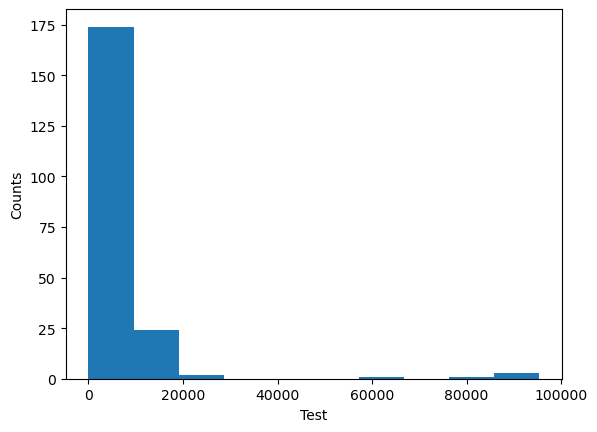

NormaltestResult(statistic=254.96596945304643, pvalue=4.313633037331286e-56)


In [150]:
# For testing normal distribution of any data
#file_path = Path('output_data/housing_homeless_data.csv')
#housing_homeless_df = pd.read_csv(file_path)

test_data = final_df['Homeless Count']
plt.hist(test_data)
plt.xlabel('Test')
plt.ylabel('Counts')
plt.show()
print(st.normaltest(test_data))

### Homelessness and Household Severe Overcrowding
Note: Household Severe Overcrowding is defined as households with more than 1.5 people per room

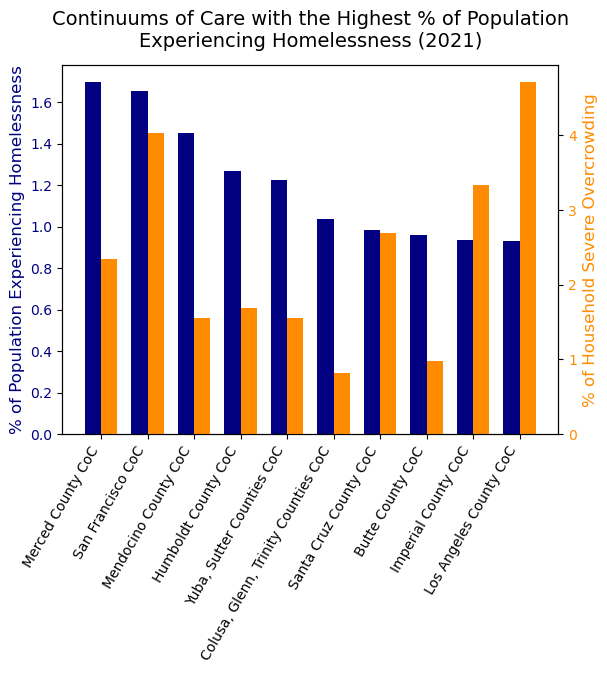

In [155]:
# Bar chart comparing household severe overcrowding and homelessness for CoCs with the highest % homeless in 2021

# Create limited dataframe for 2021, sort in descending order by % homeless and isolate the top 10 CoCs
homeless_top10 = final_df[['Continuum of Care', '% Homeless', '% Households Severely Overcrowded']][final_df['Year'] == 2021]
homeless_top10 = homeless_top10.sort_values(by='% Homeless',ascending=False).iloc[:10]

# Define parameters for function
parems = {'x': '',
          'y1': '% of Population Experiencing Homelessness',
          'y2': '% of Household Severe Overcrowding',
          'title': f'Continuums of Care with the Highest % of Population Experiencing Homelessness (2021)',
          'colors': ['navy', 'darkorange'],
          'rot': 60,
          'png_path': 'output_data/housing_overcrowdsev_top10_bar.png'
         }

plot_bar_2y(homeless_top10, parems)

### Homelessness and Severly Overcrowding Housing

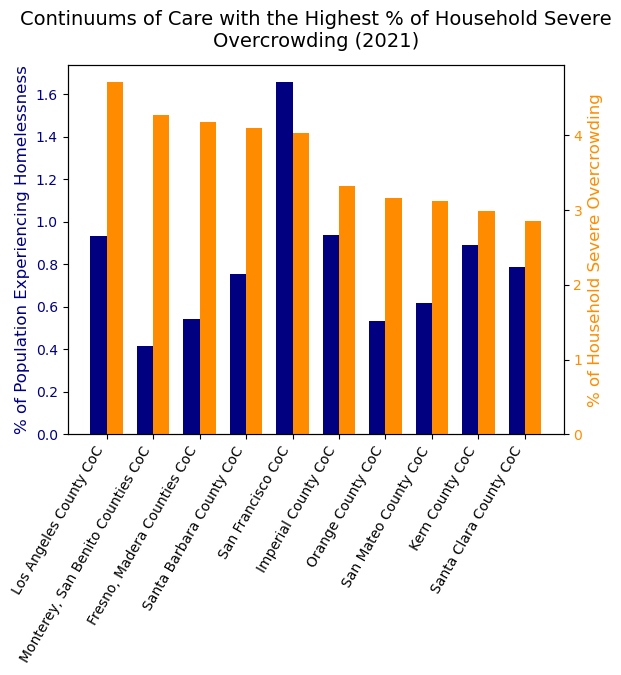

In [154]:
# Bar chart comparing household severe overcrowding and homelessness for CoCs
# with the highest % households severe overcrowding
year = 2021

# Create limited dataframe for one year, sort in descending order by % severly overcrowded housing and isolate the top 10 CoCs
fig_data = final_df[['Continuum of Care', '% Homeless', '% Households Severely Overcrowded', ]][final_df['Year'] == year]
fig_data = fig_data.sort_values(by='% Households Severely Overcrowded',ascending=False).iloc[:10]

# Define parameters for function
parems = {'x': '',
          'y1': '% of Population Experiencing Homelessness',
          'y2': '% of Household Severe Overcrowding',
          'title': f'Continuums of Care with the Highest % of Household Severe Overcrowding ({year})',
          'colors': ['navy', 'darkorange'],
          'rot': 60,
          'png_path': 'output_data/housing_overcrowdsev_top10_2_bar.png'
         }

# Call function to plot bar chart
plot_bar_2y(fig_data, parems)

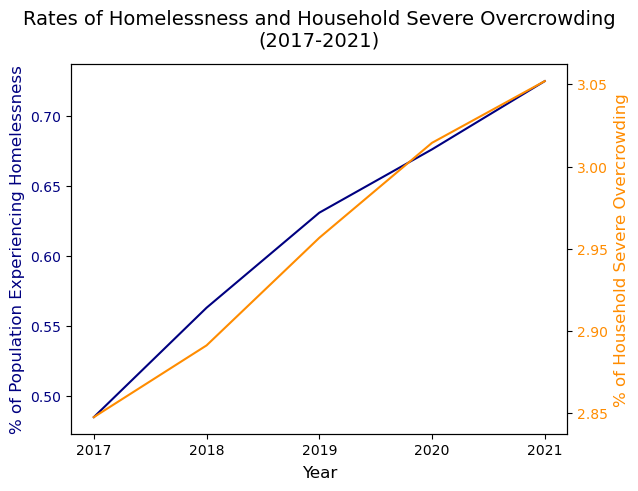

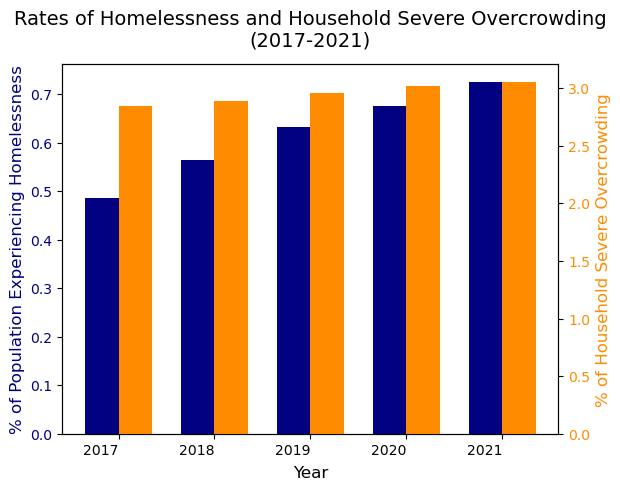

AttributeError: 'Series' object has no attribute 'value'

In [188]:
# Line and bar charts comparing annual %s for household severe overcrowding and homelessness between 2017 and 2021

# Create dataframe totalling numbers for each year and calculating %s
fig_data = final_df[['Year', 'Population', 'Homeless Count', 'Total Households', 'Households Severely Overcrowded']].groupby('Year' , as_index = False).sum()
fig_data['% Households Severely Overcrowded'] = (fig_data['Households Severely Overcrowded'] /
                                            fig_data['Total Households']) * 100

fig_data['% Homeless'] = fig_data['Homeless Count'] / fig_data['Population'] * 100

fig_data = fig_data[['Year', '% Homeless', '% Households Severely Overcrowded']]

# Define parameters for function
parems = {'x': 'Year',
          'y1': '% of Population Experiencing Homelessness',
          'y2': '% of Household Severe Overcrowding',
          'title': 'Rates of Homelessness and Household Severe Overcrowding (2017-2021)',
          'colors': ['navy', 'darkorange'], 'rot': 0,
          'png_path': 'output_data/housing_overcrowdsev_line.png' 
         }

# Call funtion to plot line chart
plot_line_2y(fig_data, parems)

# Change file name for bar chat
parems['png_path'] = 'output_data/housing_overcrowdsev_bar.png'

# Call fucntion to plot bar chart
plot_bar_2y(fig_data, parems)

In [193]:
# Additional information for analysis
print(f"Change in % Homeless: {fig_data[fig_data['Year'] == 2021]['% Homeless'].max() - fig_data[fig_data['Year'] == 2017]['% Homeless'].min()}")
print(f"Change in % Households Severely Overcrowded: {fig_data[fig_data['Year'] == 2021]['% Households Severely Overcrowded'].max() - fig_data[fig_data['Year'] == 2017]['% Households Severely Overcrowded'].min()}")

Change in % Homeless: 0.23945060889903141
Change in % Households Severely Overcrowded: 0.2047840871499611


The r value is: 0.11954197736336872
The p value is: 0.08777705665228985


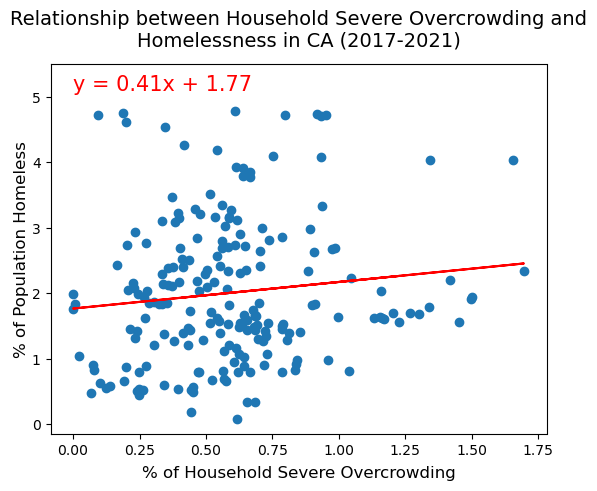

In [156]:
# Linear regression comparing households severe overcrowding and Homelessness

# Set parameters for function
parems = {'x': '% of Household Severe Overcrowding',
          'y': '% of Population Homeless',
          'title': 'Relationship between Household Severe Overcrowding and Homelessness in CA (2017-2021)',
          'png_path': 'output_data/housing_overcrowdsev_linreg.png'
         }

# Set x and y values
x_values = final_df['% Homeless']
y_values = final_df['% Households Severely Overcrowded']

# Call function to plot linear regression
plot_lin_reg(x_values, y_values, parems)

#plot_box_whiskers(final_df['% Homeless'], labels)

#### Analysis
Given the r value is 0.11, there does not appear to be a relationship between homelessness and household severe overcrowding.

The r value is: -0.10243483390815773
The p value is: 0.534910263978841


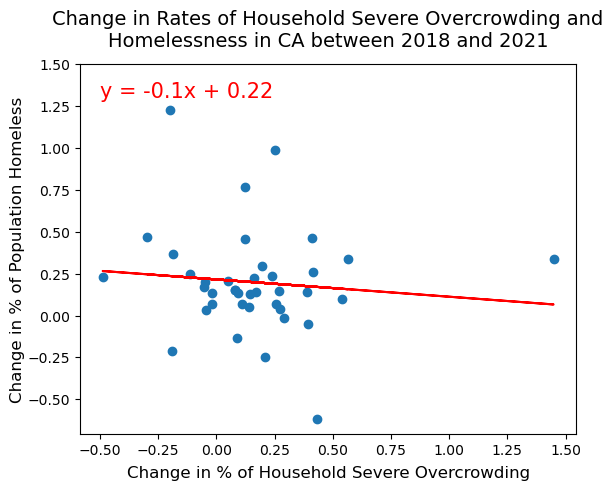

In [157]:
# Linear regression comparing change in household Severe Overcrowding and homelessness between 2 years

# Set years for comparison
year1 = 2018
year2 = 2021
data_y1 = final_df[final_df['Year'] == year1].reset_index()
data_y2 = final_df[final_df['Year'] == year2].reset_index()

# Set parameters for function
parems = {'x': 'Change in % of Household Severe Overcrowding',
          'y': 'Change in % of Population Homeless',
          'title': f'Change in Rates of Household Severe Overcrowding and Homelessness in CA between {int(year1)} and {int(year2)}',
          'png_path': 'output_data/housing_overcrowdsev_linreg2.png'
         }

# Calculate % change from year 1 to year 2
x_values = data_y2['% Households Severely Overcrowded'] - data_y1['% Households Severely Overcrowded']
y_values = data_y2['% Homeless'] - data_y1['% Homeless']

x_values = x_values.drop([x_values.index[12], x_values.index[16]])
y_values = y_values.drop([y_values.index[12], y_values.index[16]])
x_values.reset_index()
y_values.reset_index()

# Call function to plot linear regression
plot_lin_reg(x_values, y_values, parems)

#### Analysis
Given the r value is -0.10, there does not appear to be a relationship between the change in rates of homelessness and household severe overcrowding between 2018 and 2021.

### Homelessness and Households with Housing Cost Burden
Households with housing cost burden are defined as households that spend more than 30% of their income on rent, mortgage and other housing needs.

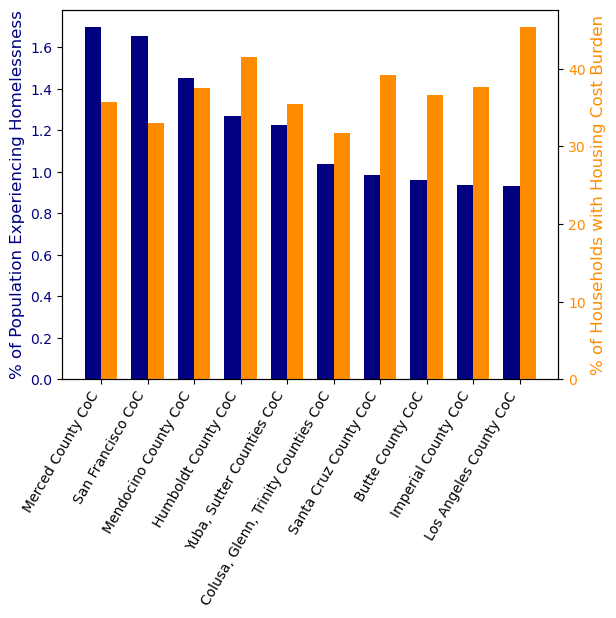

In [121]:
# Bar chart comparing housing cost burden and homelessness for CoCs with the highest % homeless in one year
year = 2021

# Create limited dataframe for one year, sort in descending order by % homeless and isolate the top 10 CoCs
fig_data = final_df[['Continuum of Care', '% Homeless', '% Households with Cost Burden']][final_df['Year'] == year]
fig_data = fig_data.sort_values(by='% Homeless',ascending=False).iloc[:10]

# Set parameters for function
parems = {'x': '',
          'y1': '% of Population Experiencing Homelessness',
          'y2': '% of Households with Housing Cost Burden',
          'title': '', #f'Continuums of Care with the Highest % of Population Experiencing Homelessness ({year})',
          'colors': ['navy', 'darkorange'],
          'rot': 60,
          'png_path': 'output_data/housing_costburden_top10_bar.png'
         }

# Call function to plot bar chart
plot_bar_2y(fig_data, parems)

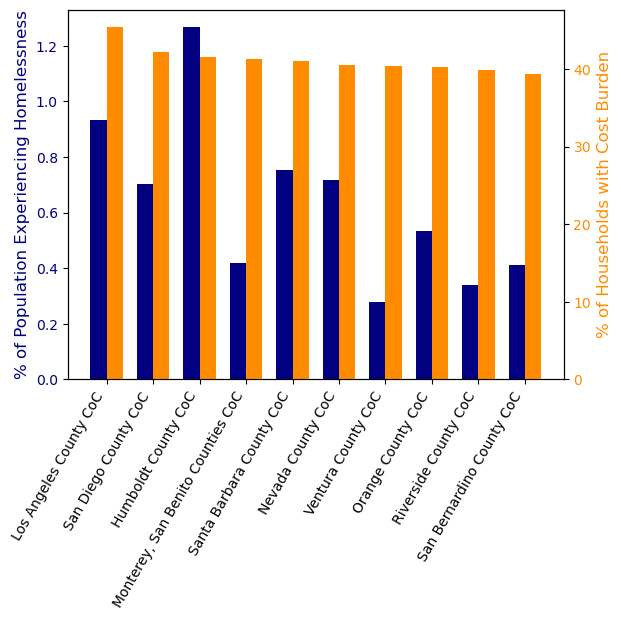

In [122]:
# Bar chart comparing households cost burden and homelessness for CoCs with the highest % housing cost burden in one year
year = 2021

# Create limited dataframe for one year, sort in descending order by % households with cost burden and isolate the top 10 CoCs
fig_data = final_df[['Continuum of Care', '% Homeless', '% Households with Cost Burden', ]][final_df['Year'] == year]
fig_data = fig_data.sort_values(by='% Households with Cost Burden',ascending=False).iloc[:10]

# Define parameters for function
parems = {'x': '',
          'y1': '% of Population Experiencing Homelessness',
          'y2': '% of Households with Cost Burden',
          'title': '', #f'Continuums of Care with the Highest % of Households with Cost Burden ({year})',
          'colors': ['navy', 'darkorange'],
          'rot': 60,
          'png_path': 'output_data/housing_costburden_top10_2_bar.png'
         }

# Call function to plot bar chart
plot_bar_2y(fig_data, parems)

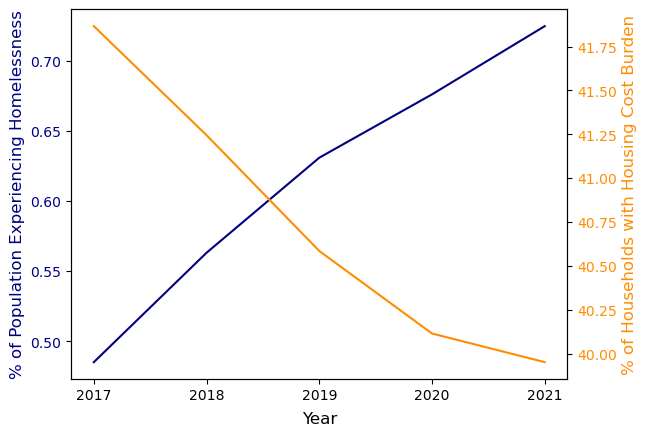

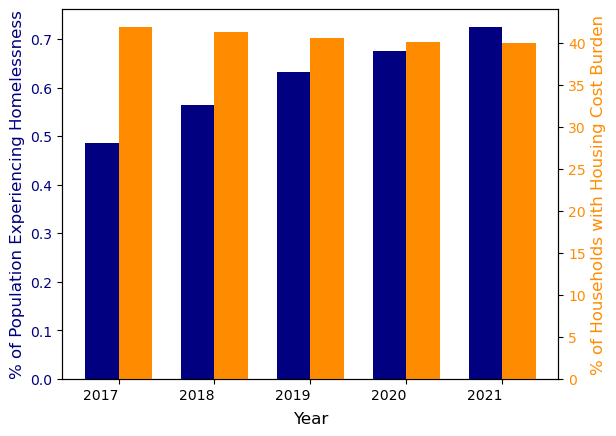

In [195]:
# Line and bar chart comparing annual %s for households with housing cost burden and homelessness between 2017 and 2021

# Create dataframe totalling numbers for each year and calculating %s
fig_data = final_df[['Year', 'Population', 'Homeless Count', 'Total Households',
                     'Households with Cost Burden']].groupby('Year' , as_index = False).sum()
fig_data['% Households with Cost Burden'] = (fig_data['Households with Cost Burden'] /
                                  fig_data['Total Households']) * 100
fig_data['% Homeless'] = fig_data['Homeless Count'] / fig_data['Population'] * 100
fig_data = fig_data[['Year', '% Homeless', '% Households with Cost Burden']]

# Set parameters for function
parems = {'x': 'Year',
          'y1': '% of Population Experiencing Homelessness',
          'y2': '% of Households with Housing Cost Burden',
          'title': '', #'Rates of Homelessness and Households with Housing Cost Burden in CA (2017-2021)',
          'colors': ['navy', 'darkorange'], 'rot': 0,
          'png_path': 'output_data/housing_costburden_line.png'
         }

# Call funtion to plot line chart
plot_line_2y(fig_data, parems)

# Change file name for bar chat
parems['png_path'] = 'output_data/housing_costburden_bar.png'

# Call fucntion to plot bar chart
plot_bar_2y(fig_data, parems)

In [198]:
# Additional information for analysis
print(f"Change in % Homeless: {fig_data[fig_data['Year'] == 2021]['% Homeless'].max() - fig_data[fig_data['Year'] == 2017]['% Homeless'].min()}")
print(f"Change in % Households with Housing Cost Burden: {fig_data[fig_data['Year'] == 2021]['% Households with Cost Burden'].max() - fig_data[fig_data['Year'] == 2017]['% Households with Cost Burden'].min()}")
print(f"% Households with Housing Cost Burden in 2021: {fig_data[fig_data['Year'] == 2021]['% Households with Cost Burden'].max()}")

Change in % Homeless: 0.23945060889903141
Change in % Households with Housing Cost Burden: -1.9127385752967996
% Households with Housing Cost Burden in 2021: 39.95355884198521


The r value is: -0.010747924595925816
The p value is: 0.8784374684784902


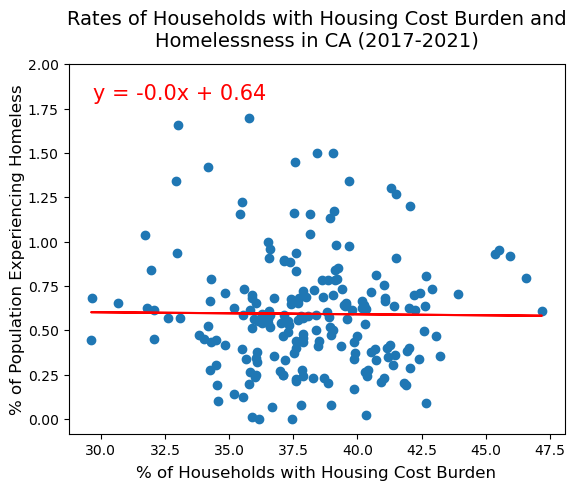

In [158]:
# Linear regression comparing households with housing cost burden and homelessness

# Define parameters for function
parems = {'x': '% of Households with Housing Cost Burden',
          'y': '% of Population Experiencing Homeless',
          'title': 'Rates of Households with Housing Cost Burden and Homelessness in CA (2017-2021)',
          'png_path': 'output_data/housing_costburden_linreg.png'
         }

# Set x and y values
x_values = final_df['% Households with Cost Burden']
y_values = final_df['% Homeless']

# Call function to plot linear regression
plot_lin_reg(x_values, y_values, parems)

#plot_box_whiskers(x_values, parems)

#### Analysis
Given the r value is -0.01, there does not appear to be a relationship between homelessness and households with housing cost burden.

The r value is: -0.0049329024709242365
The p value is: 0.9755811001043537


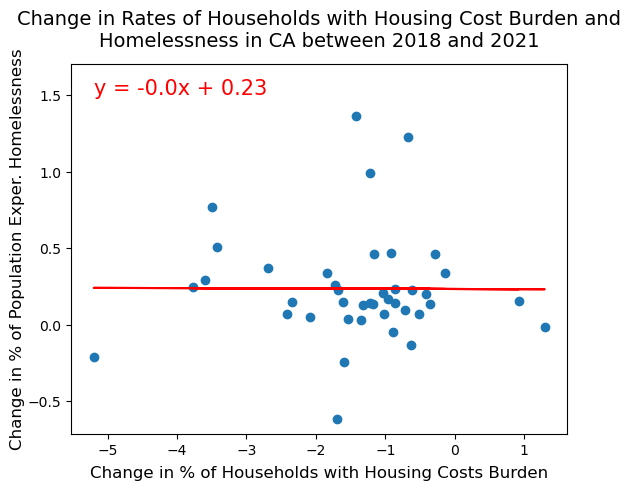

In [159]:
# Linear regression comparing change in households with housing cost burden and homelessness between 2 years

# Set years for comparison
year1 = 2018
year2 = 2021
data_y1 = final_df[final_df['Year'] == year1].reset_index()
data_y2 = final_df[final_df['Year'] == year2].reset_index()

# Set parameters for function
parems = {'x': 'Change in % of Households with Housing Costs Burden',
          'y': 'Change in % of Population Exper. Homelessness',
          'title': f'Change in Rates of Households with Housing Cost Burden and Homelessness in CA between {int(year1)} and {int(year2)}',
          'png_path': 'output_data/housing_cost_burden_linreg2.png'
         }

# Calculate % change from year 1 to year 2
x_values = data_y2['% Households with Cost Burden'] - data_y1['% Households with Cost Burden']
y_values = data_y2['% Homeless'] - data_y1['% Homeless']

# Call function to plot linear regression
plot_lin_reg(x_values, y_values, parems)

#### Analysis
Given the r value is -0.04, there does not appear to be a relationship between the change in rates of homelessness and households with housing cost burden between 2018 and 2021.

## Conclusions

According to data from California's Open Portal, the number of people experiencing homelessness has increased from 189K to 285K between 2017 and 2021, representing a 51% increase. This underscores the importance of understanding the causes and factors that influence homelessness. The focus of the above analysis was on the relationship with housing, specifically household severe overcrowding and households with housing cost burden.

Given the homelessness data was summarized by Continuums of Care (CoC) in California and these regions varied widely in size and population, it was necessary to compare the homelessness and housing data as a percentage of the total population and total number of households respectively. In looking first at household severe overcrowding, a simple comparison with homelessness by year showed both increased between 2017 and 2021 albeit by 0.23% for homelessness and 0.20% for severe overcrowding. A linear regression using data for each Continuum of Care over those years resulted in an r-value of 0.12 indicating no apparent relationship. This was surprising given several articles about their relationship.

When looking at the ten Contiunums of Care with the highest percentage of the population experiencing homelessness, only three counties - Los Angeles, San Francisco, and Imperial - were also one of the ten Contiunums of Care with the highest percentage  of household severe overcrowding. All three of these regions are densely populated and this may indicate that the variations between the regions may be influencing the relationship. It would be beneficial to look more closely at the characteristics of the different Continuums of Care possibly grouping them by geography and population density for further analysis. City level data on homelessness would also allow more targeted comparisons and differentiation between urban and rural areas.

As for households with housing cost burden, a year by year comparison revealed that housing cost burden decreased by 1.9% between 2017 and 2021. That said there were stil A linear regression resulted in an r-value of -0.01, again indicating no apparent relationship. This was surprising as well and supports further analysis. It was also sobering that 40% of households in California in 2021 were housing cost burdened and spent 30% of their income on housing. 

Overall, this project was challenging and enlightening in several areas. The biggest challenge was limited data regarding the homeless population in California and the difficulty in accurately tracking the population as they utilize various public services and report their living status. It was also challenging to dive into the depths of the US Census Bureau API and understand the methodology and data variables within the American Community Survey. It was enlightening to work with a group on a project for the first time. I think we worked well together but I do think we could have narrowed our focus and limited our datasets. We essentially had separate mini-projects which made it difficult for us to share what we were learning and assist each other.

## Additional Analysis and Visualizations (not included in presentation)

### Homelessness and Household Overcrowding
Note: Household Overcrowding is defined as households with more than 1 person per room

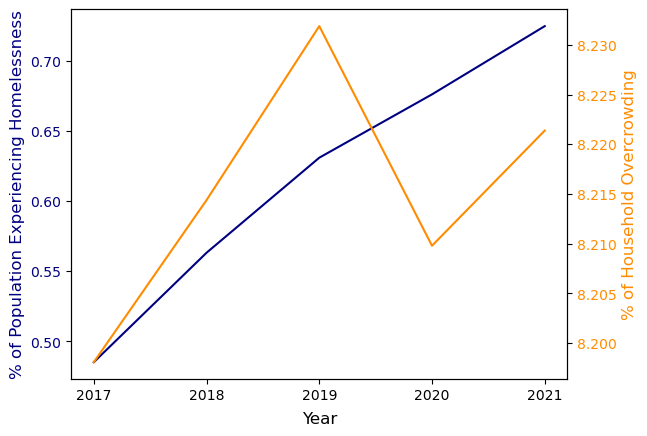

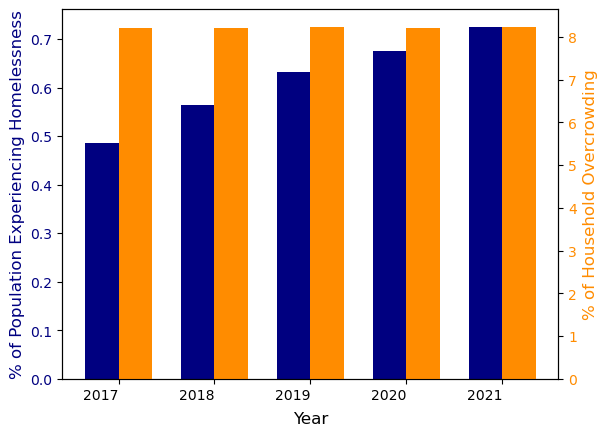

In [174]:
# Line and bar charts comparing annual %s for overcrowded housing and homelessness between 2017 and 2021

# Create dataframe totalling numbers for each year and calculating %s
fig_data = final_df[['Year', 'Population', 'Homeless Count', 'Total Households', 'Households Overcrowded']].groupby('Year' , as_index = False).sum()
fig_data['% Households Overcrowded'] = (fig_data['Households Overcrowded'] /
                                            fig_data['Total Households']) * 100

fig_data['% Homeless'] = fig_data['Homeless Count'] / fig_data['Population'] * 100
fig_data = fig_data[['Year', '% Homeless', '% Households Overcrowded']]

# Define parameters for function
parems = {'x': 'Year',
          'y1': '% of Population Experiencing Homelessness',
          'y2': '% of Household Overcrowding',
          'title': '', #'Rates of Household Overcrowding and Homelessness in CA (2017-2021)',
          'colors': ['navy', 'darkorange'], 'rot': 0,
          'png_path': 'output_data/housing_overcrowd_line.png'
         }

# Call funtion to plot line chart
plot_line_2y(fig_data, parems)

# Change file name for bar chat
parems['png_path'] = 'output_data/housing_overcrowd_bar.png'

# Call fucntion to plot bar chart
plot_bar_2y(fig_data, parems)

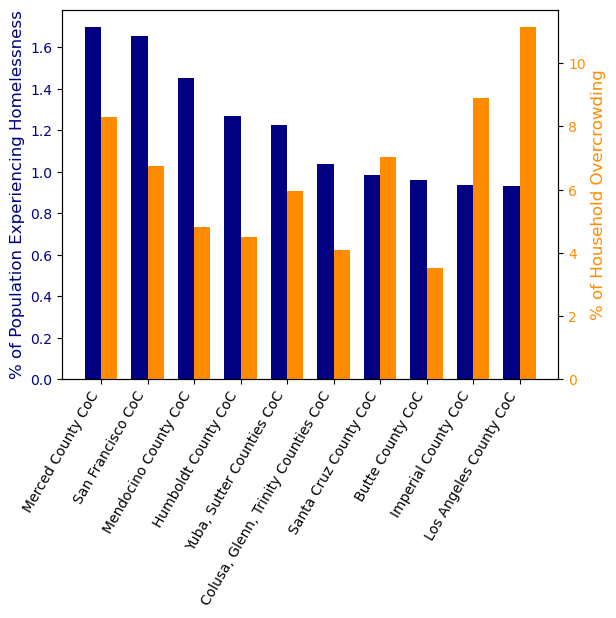

In [109]:
# Bar chart comparing homelessness and household overcrowding for CoCs with the highest % homeless in one year
year = 2021

# Create limited dataframe for one year, sort in descending order by % homeless and isolate the top 10 CoCs
fig_data = final_df[['Continuum of Care', '% Homeless', '% Households Overcrowded']][final_df['Year'] == year]
fig_data = fig_data.sort_values(by='% Homeless',ascending=False).iloc[:10]

# Define parameters for function
parems = {'x': '',
          'y1': '% of Population Experiencing Homelessness',
          'y2': '% of Household Overcrowding',
          'title': '', #f'Continuums of Care with the Highest % of Population Experiencing Homelessness ({year})',
          'colors': ['navy', 'darkorange'],
          'rot': 60,
          'png_path': 'output_data/housing_overcrowd_top10_bar.png'
         }
# Call function to plot bar chart
plot_bar_2y(fig_data, parems)

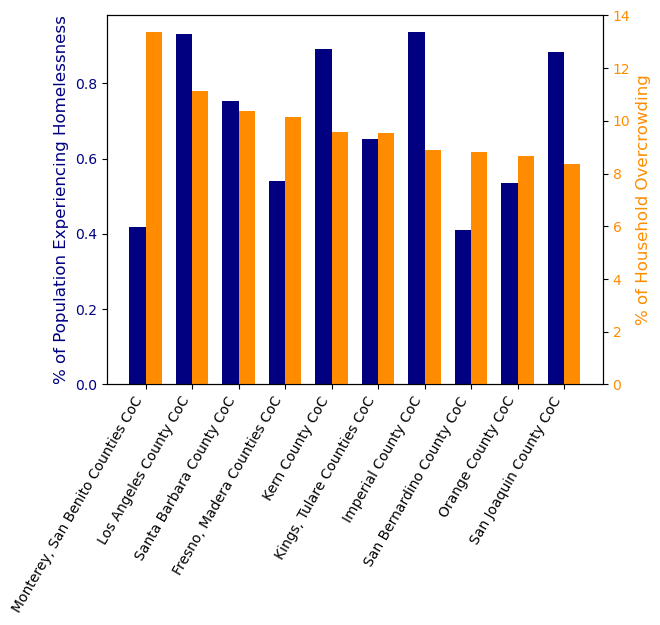

In [110]:
# Bar chart comparing household overcrowding and homelessness for CoCs with the highest % overcrowded housing in 2021
year = 2021

# Create limited dataframe for one year, sort in descending order by % overcrowded housing and isolate the top 10 CoCs
fig_data = final_df[['Continuum of Care', '% Homeless', '% Households Overcrowded', ]][final_df['Year'] == year]
fig_data = fig_data.sort_values(by='% Households Overcrowded',ascending=False).iloc[:10]

# Define parameters for function
parems = {'x': '',
          'y1': '% of Population Experiencing Homelessness',
          'y2': '% of Household Overcrowding',
          'title': '', #f'Continuums of Care with the Highest % of Household Overcrowding ({year})',
          'colors': ['navy', 'darkorange'],
          'rot': 60,
          'png_path': 'output_data/housing_overcrowd_top10_2_bar.png'
         }

# Call function to plot bar chart
plot_bar_2y(fig_data, parems)

The r value is: 0.06577725529301552
The p value is: 0.3487362119573699


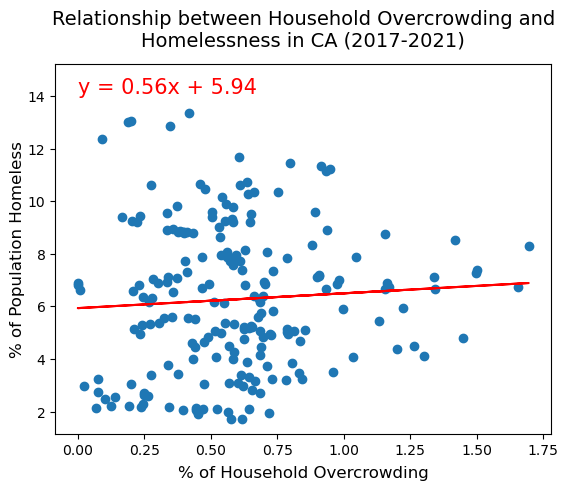

In [170]:
# Linear regression comparing overcrowded housing and homelessness

# Set parameters for function
parems = {'x': '% of Household Overcrowding',
          'y': '% of Population Homeless',
          'title': 'Relationship between Household Overcrowding and Homelessness in CA (2017-2021)',
          'png_path': 'output_data/housing_overcrowd_linreg.png'
         }

# Set x and y values
x_values = final_df['% Homeless']
y_values = final_df['% Households Overcrowded']

# Call function to plot linear regression
plot_lin_reg(x_values, y_values, parems)

#### Analysis
Given the r value is 0.07, there does not appear to be a relationship between homelessness and household overcrowding.